Reading data from: /content/final_clean_to_do_interaction_features.csv
Successfully read data. Shape: (5618, 68)

Value counts for MYCS_Group:
MYCS_Group
<= 1.0    5425
> 1.0      193
Name: count, dtype: int64

Generating plot...


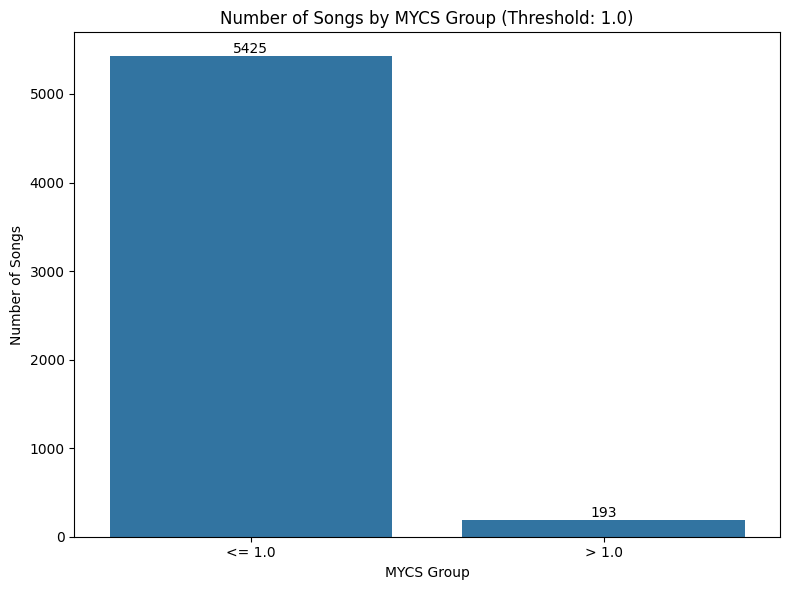

Plot displayed.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

!!
data_file_path = '/content/final_clean_to_do_interaction_features.csv'
mycs_threshold = 1.0

try:

    print(f"Reading data from: {data_file_path}")
    if data_file_path.endswith('.csv'):
        df = pd.read_csv(data_file_path)

    if df is not None:
        print(f"Successfully read data. Shape: {df.shape}")


        if 'MYCS' not in df.columns:
            print("Error: 'MYCS' column not found in the DataFrame.", file=sys.stderr)
        else:
            df_plot = df.dropna(subset=['MYCS']).copy()

            df_plot['MYCS_Group'] = np.where(df_plot['MYCS'] > mycs_threshold,
                                             f'> {mycs_threshold}',
                                             f'<= {mycs_threshold}')

            group_counts = df_plot['MYCS_Group'].value_counts()
            print(f"\nValue counts for MYCS_Group:\n{group_counts}")

            print("\nGenerating plot...")
            plt.figure(figsize=(8, 6))

            plot_order = [f'<= {mycs_threshold}', f'> {mycs_threshold}']
            if not all(item in group_counts.index for item in plot_order):
                 plot_order = group_counts.index

            ax = sns.countplot(data=df_plot, x='MYCS_Group', order=plot_order)

            for container in ax.containers:
                ax.bar_label(container)

            plt.title(f'Number of Songs by MYCS Group (Threshold: {mycs_threshold})')
            plt.xlabel('MYCS Group')
            plt.ylabel('Number of Songs')


            plt.tight_layout()
            plt.show()
            print("Plot displayed.")

except FileNotFoundError:
    print(f"Error: The file '{data_file_path}' was not found.", file=sys.stderr)
    print("Please make sure the file exists and the path is correct.", file=sys.stderr)
except Exception as e:
    print(f"\nAn error occurred: {e}", file=sys.stderr)



Starting initial preprocessing...

Target variable 'is_high_performer' created.
Value counts for target:
is_high_performer
0    5246
1     190
Name: count, dtype: int64

Starting Feature Engineering...

Performing Train-Test Split...
Train size: 4348, Test size: 1088
Train target distribution:
is_high_performer
0    0.965041
1    0.034959
Name: proportion, dtype: float64
Test target distribution:
is_high_performer
0    0.965074
1    0.034926
Name: proportion, dtype: float64

Applying TF-IDF to lyrics (removing stopwords)...

Combining numerical/engineered features with TF-IDF features...
Total number of features after combining: 562

Scaling combined feature set...

Training LightGBM Classifier model with class_weight='balanced'...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 152, number of negative: 4196
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55295
[LightGBM] [Info] Number of data points in the train set: 4348, number of used features: 558
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Model training finished in 2.85 seconds.

--- Binary Classification Performance Metrics ---

Classification Report:
              precision    recall  f1-score   support

 MYCS <= 1.0       0.96      1.00      0.98      1050
  MYCS > 1.0       0.00      0.00      0.00        38

    accuracy                           0.96      1088
   macro avg       0.48      0.50      0.49      1088
weighted avg       0.93      0.96      0.95      1088


Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


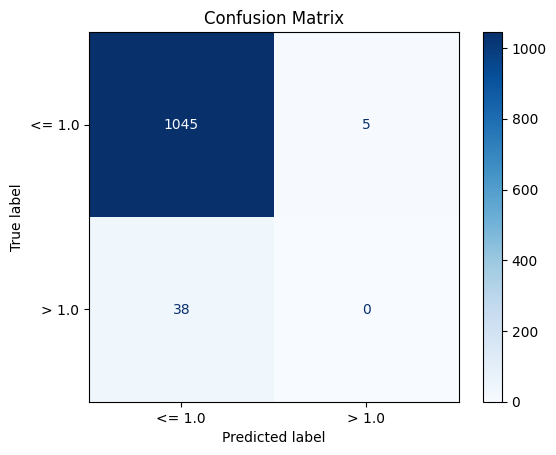


ROC AUC Score: 0.7081
Precision-Recall AUC Score: 0.0901


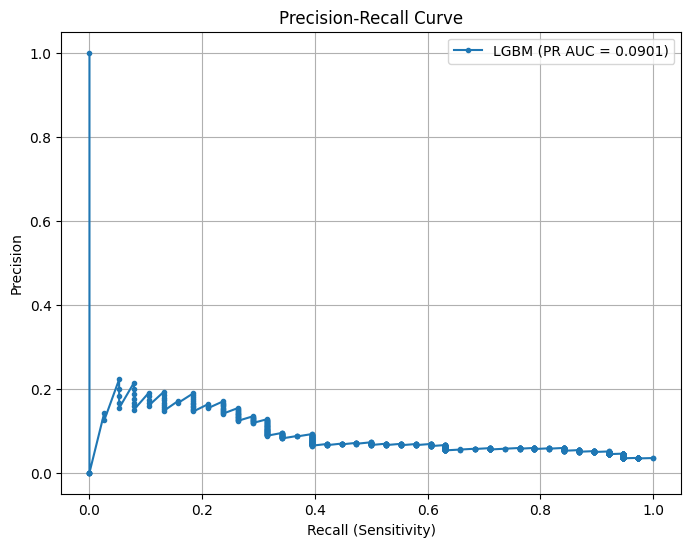

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import sys
import time


mycs_threshold = 1.0


lyrics_col_name = 'lyrics_cleaned' if 'lyrics_cleaned' in df.columns else 'lyrics'
if lyrics_col_name not in df.columns:
    print(f"ERROR: Neither 'lyrics_cleaned' nor 'lyrics' found in DataFrame.", file=sys.stderr)

original_drops = [
    'song', 'artist', 'year', 'ranking', 'MYCS',
    'unique_words', 'pattern'
]
if 'lyrics_cleaned' in df.columns and 'lyrics' in df.columns:
    other_lyrics = 'lyrics' if lyrics_col_name == 'lyrics_cleaned' else 'lyrics_cleaned'
    original_drops.append(other_lyrics)

columns_to_drop_updated = original_drops

print("Starting initial preprocessing...")
df_processed = df.copy()
df_processed = df_processed.dropna(subset=['MYCS'])
df_processed = df_processed.dropna(subset=[lyrics_col_name])

target_col = 'is_high_performer'
df_processed[target_col] = (df_processed['MYCS'] > mycs_threshold).astype(int)
print(f"\nTarget variable '{target_col}' created.")
print(f"Value counts for target:\n{df_processed[target_col].value_counts()}")

y = df_processed[target_col]

columns_to_drop_existing = [col for col in columns_to_drop_updated if col in df_processed.columns]
X = df_processed.drop(columns=columns_to_drop_existing + [target_col], errors='ignore')

print("\nStarting Feature Engineering...")
if 'total_section_count' in X.columns and 'chorus_sentiment_shift' in X.columns:
    X['interact_tsc_css'] = X['total_section_count'] * X['chorus_sentiment_shift']
if 'total_section_count' in X.columns:
    X['tsc_sq'] = X['total_section_count']**2
if 'chorus_sentiment_shift' in X.columns:
    X['css_sq'] = X['chorus_sentiment_shift']**2

lyrics_data = X.pop(lyrics_col_name)

X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.mean())
numerical_feature_names = X.columns.tolist()

print("\nPerforming Train-Test Split...")
X_train_num, X_test_num, lyrics_train, lyrics_test, y_train, y_test = train_test_split(
    X, lyrics_data, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {X_train_num.shape[0]}, Test size: {X_test_num.shape[0]}")
print(f"Train target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")

print("\nApplying TF-IDF to lyrics (removing stopwords)...")
vectorizer = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1, 2))
tfidf_train_sparse = vectorizer.fit_transform(lyrics_train)
tfidf_test_sparse = vectorizer.transform(lyrics_test)
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), columns=tfidf_feature_names)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), columns=tfidf_feature_names)

print("\nCombining numerical/engineered features with TF-IDF features...")
X_train_combined = pd.concat([X_train_num.reset_index(drop=True), tfidf_train_df], axis=1)
X_test_combined = pd.concat([X_test_num.reset_index(drop=True), tfidf_test_df], axis=1)
combined_feature_names = X_train_combined.columns.tolist()
print(f"Total number of features after combining: {len(combined_feature_names)}")

print("\nScaling combined feature set...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

print("\nTraining LightGBM Classifier model with class_weight='balanced'...")
model_lgbm_clf = lgb.LGBMClassifier(objective='binary',
                                    metric='auc',
                                    class_weight='balanced',
                                    random_state=42,
                                    n_jobs=-1)
start_time = time.time()
model_lgbm_clf.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"Model training finished in {end_time - start_time:.2f} seconds.")

y_pred_clf = model_lgbm_clf.predict(X_test_scaled)
y_pred_proba_clf = model_lgbm_clf.predict_proba(X_test_scaled)[:, 1]

print("\n--- Binary Classification Performance Metrics ---")


print("\nClassification Report:")
print(classification_report(y_test, y_pred_clf, target_names=[f'MYCS <= {mycs_threshold}', f'MYCS > {mycs_threshold}']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'<= {mycs_threshold}', f'> {mycs_threshold}'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_proba_clf)
print(f"\nROC AUC Score: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_clf)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'LGBM (PR AUC = {pr_auc:.4f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()



Insufficent at identifying high performers

Songs in top 20 each year

Starting initial preprocessing...

Target variable 'is_high_performer' created.
Value counts for target:
is_high_performer
0    4138
1    1298
Name: count, dtype: int64

Starting Feature Engineering...

Performing Train-Test Split...
Train size: 4348, Test size: 1088
Train target distribution:
is_high_performer
0    0.76127
1    0.23873
Name: proportion, dtype: float64
Test target distribution:
is_high_performer
0    0.761029
1    0.238971
Name: proportion, dtype: float64

Applying TF-IDF to lyrics (removing stopwords)...

Combining numerical/engineered features with TF-IDF features...
Total number of features after combining: 562

Scaling combined feature set...

Training LightGBM Classifier model with class_weight='balanced'...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1038, number of negative: 3310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55270
[LightGBM] [Info] Number of data points in the train set: 4348, number of used features: 559
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Model training finished in 2.41 seconds.

--- Binary Classification Performance Metrics ---

Classification Report:
              precision    recall  f1-score   support

MYCS <= 0.79       0.78      0.79      0.78       828
 MYCS > 0.79       0.29      0.28      0.29       260

    accuracy                           0.67      1088
   macro avg       0.53      0.53      0.53      1088
weighted avg       0.66      0.67      0.66      1088



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


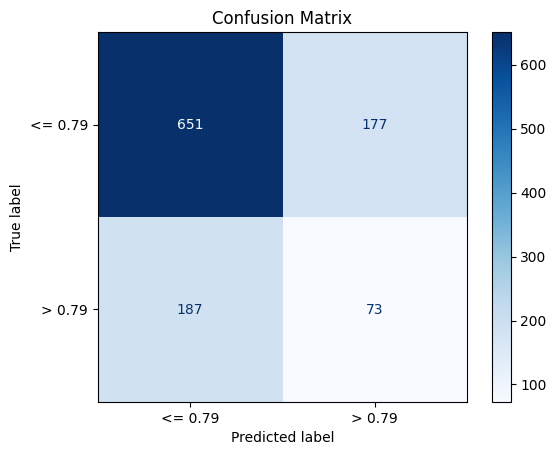


ROC AUC Score: 0.6186
Precision-Recall AUC Score: 0.2931


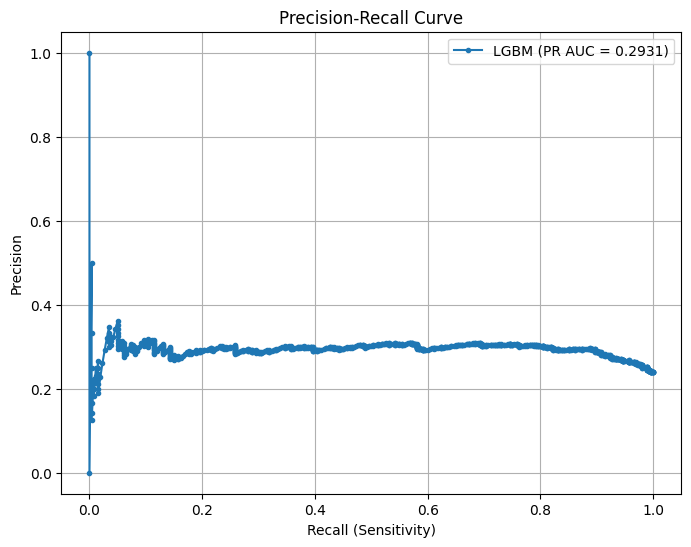

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import sys
import time


mycs_threshold = 0.79


lyrics_col_name = 'lyrics_cleaned' if 'lyrics_cleaned' in df.columns else 'lyrics'
if lyrics_col_name not in df.columns:
    print(f"ERROR: Neither 'lyrics_cleaned' nor 'lyrics' found in DataFrame.", file=sys.stderr)

original_drops = [
    'song', 'artist', 'year', 'ranking', 'MYCS',
    'unique_words', 'pattern'
]
if 'lyrics_cleaned' in df.columns and 'lyrics' in df.columns:
    other_lyrics = 'lyrics' if lyrics_col_name == 'lyrics_cleaned' else 'lyrics_cleaned'
    original_drops.append(other_lyrics)

columns_to_drop_updated = original_drops

print("Starting initial preprocessing...")
df_processed = df.copy()
df_processed = df_processed.dropna(subset=['MYCS'])
df_processed = df_processed.dropna(subset=[lyrics_col_name])

target_col = 'is_high_performer'
df_processed[target_col] = (df_processed['MYCS'] > mycs_threshold).astype(int)
print(f"\nTarget variable '{target_col}' created.")
print(f"Value counts for target:\n{df_processed[target_col].value_counts()}")

y = df_processed[target_col]

columns_to_drop_existing = [col for col in columns_to_drop_updated if col in df_processed.columns]
X = df_processed.drop(columns=columns_to_drop_existing + [target_col], errors='ignore')

print("\nStarting Feature Engineering...")
if 'total_section_count' in X.columns and 'chorus_sentiment_shift' in X.columns:
    X['interact_tsc_css'] = X['total_section_count'] * X['chorus_sentiment_shift']
if 'total_section_count' in X.columns:
    X['tsc_sq'] = X['total_section_count']**2
if 'chorus_sentiment_shift' in X.columns:
    X['css_sq'] = X['chorus_sentiment_shift']**2

lyrics_data = X.pop(lyrics_col_name)

X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.mean())
numerical_feature_names = X.columns.tolist()

print("\nPerforming Train-Test Split...")
X_train_num, X_test_num, lyrics_train, lyrics_test, y_train, y_test = train_test_split(
    X, lyrics_data, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {X_train_num.shape[0]}, Test size: {X_test_num.shape[0]}")
print(f"Train target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")

print("\nApplying TF-IDF to lyrics (removing stopwords)...")
vectorizer = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1, 2))
tfidf_train_sparse = vectorizer.fit_transform(lyrics_train)
tfidf_test_sparse = vectorizer.transform(lyrics_test)
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), columns=tfidf_feature_names)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), columns=tfidf_feature_names)

print("\nCombining numerical/engineered features with TF-IDF features...")
X_train_combined = pd.concat([X_train_num.reset_index(drop=True), tfidf_train_df], axis=1)
X_test_combined = pd.concat([X_test_num.reset_index(drop=True), tfidf_test_df], axis=1)
combined_feature_names = X_train_combined.columns.tolist()
print(f"Total number of features after combining: {len(combined_feature_names)}")

print("\nScaling combined feature set...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

print("\nTraining LightGBM Classifier model with class_weight='balanced'...")
model_lgbm_clf = lgb.LGBMClassifier(objective='binary',
                                    metric='auc',
                                    class_weight='balanced',
                                    random_state=42,
                                    n_jobs=-1)
start_time = time.time()
model_lgbm_clf.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"Model training finished in {end_time - start_time:.2f} seconds.")

y_pred_clf = model_lgbm_clf.predict(X_test_scaled)
y_pred_proba_clf = model_lgbm_clf.predict_proba(X_test_scaled)[:, 1]

print("\n--- Binary Classification Performance Metrics ---")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_clf, target_names=[f'MYCS <= {mycs_threshold}', f'MYCS > {mycs_threshold}']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'<= {mycs_threshold}', f'> {mycs_threshold}'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_proba_clf)
print(f"\nROC AUC Score: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_clf)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'LGBM (PR AUC = {pr_auc:.4f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()



In [ ]:
import pandas as pd
import ast
import sys

input_file_path = '/content/final_clean_to_do_interaction_features.csv'
output_file_path = 'expanded_song_data.csv'

def parse_list_string(list_str):
    """Safely parses a string representation of a list."""
    try:
        if pd.isna(list_str) or not isinstance(list_str, str):
            return None
        parsed_list = ast.literal_eval(list_str)
        if isinstance(parsed_list, list):
            return parsed_list
        elif isinstance(parsed_list, (int, float)):
             return [parsed_list]
        else:
            return None
    except (ValueError, SyntaxError, TypeError):
        print(f"Warning: Could not parse list string: {list_str}", file=sys.stderr)
        return None

try:
    print(f"Reading data from: {input_file_path}")
    if input_file_path.endswith('.csv'):
        df = pd.read_csv(input_file_path)
    elif input_file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(input_file_path)
    else:
        print(f"Error: Unsupported file format for {input_file_path}. Please use CSV or Excel.", file=sys.stderr)
        df = None

    if df is not None:
        print(f"Successfully read data. Shape: {df.shape}")

        print("Parsing 'year' and 'ranking' columns...")
        df['year_list'] = df['year'].apply(parse_list_string)
        df['ranking_list'] = df['ranking'].apply(parse_list_string)

        original_rows = len(df)
        df.dropna(subset=['year_list', 'ranking_list'], inplace=True)
        if len(df) < original_rows:
            print(f"Dropped {original_rows - len(df)} rows due to parsing errors in 'year' or 'ranking'.")

        mismatched_lengths = df[df['year_list'].str.len() != df['ranking_list'].str.len()]
        if not mismatched_lengths.empty:
            print(f"\nWarning: Found {len(mismatched_lengths)} rows where the number of years and rankings differ.", file=sys.stderr)
            print("These rows will be dropped:", file=sys.stderr)
            print(mismatched_lengths[['song', 'artist', 'year', 'ranking']], file=sys.stderr)
            df = df[df['year_list'].str.len() == df['ranking_list'].str.len()]

        print("Exploding DataFrame based on year and ranking lists...")
        cols_to_keep = ['song', 'artist', 'MYCS']
        other_cols = [col for col in cols_to_keep if col in df.columns]

        new_rows = []
        for _, row in df.iterrows():
            base_data = {col: row[col] for col in other_cols}
            years = row['year_list']
            rankings = row['ranking_list']
            for i in range(len(years)):
                new_row = base_data.copy()
                new_row['year'] = years[i]
                new_row['ranking'] = rankings[i]
                new_rows.append(new_row)

        df_expanded = pd.DataFrame(new_rows)

        final_cols = ['song', 'artist', 'year', 'ranking', 'MYCS'] + [col for col in other_cols if col not in ['song', 'artist', 'MYCS']]
        final_cols = [col for col in final_cols if col in df_expanded.columns]
        df_expanded = df_expanded[final_cols]

        print(f"Expanded DataFrame created. Shape: {df_expanded.shape}")
        print("\nFirst 5 rows of the expanded DataFrame:")
        print(df_expanded.head())

        print(f"\nSaving expanded data to: {output_file_path}")
        df_expanded.to_csv(output_file_path, index=False)
        print("File saved successfully.")

except FileNotFoundError:
    print(f"Error: The file '{input_file_path}' was not found.", file=sys.stderr)
    print("Please make sure the file exists and the path is correct.", file=sys.stderr)
except Exception as e:
    print(f"\nAn error occurred during the process: {e}", file=sys.stderr)



Reading data from: /content/final_clean_to_do_interaction_features.csv
Successfully read data. Shape: (5618, 68)
Parsing 'year' and 'ranking' columns...
Exploding DataFrame based on year and ranking lists...
Expanded DataFrame created. Shape: (5898, 5)

First 5 rows of the expanded DataFrame:
              song         artist  year  ranking   MYCS
0  Blinding Lights     The Weeknd  2020        1  2.376
1  Blinding Lights     The Weeknd  2021        3  2.376
2    how do i live    leann rimes  1997        9  2.256
3    how do i live    leann rimes  1998        5  2.256
4             Stay  Justin Bieber  2021       12  2.244

Saving expanded data to: expanded_song_data.csv
File saved successfully.


In [ ]:
import pandas as pd
import ast
import sys


input_file_path = '/content/final_clean_to_do_interaction_features.csv'
output_file_path = 'expanded_song_data_all_cols.csv'

def parse_list_string(list_str):
    """Safely parses a string representation of a list."""
    try:
        if pd.isna(list_str) or not isinstance(list_str, str):
            return None
        parsed_list = ast.literal_eval(list_str)
        if isinstance(parsed_list, list):
            return parsed_list
        elif isinstance(parsed_list, (int, float)):
             return [parsed_list]
        else:
            return None
    except (ValueError, SyntaxError, TypeError):
        print(f"Warning: Could not parse list string: {list_str}", file=sys.stderr)
        return None

try:
    print(f"Reading data from: {input_file_path}")
    if input_file_path.endswith('.csv'):
        df = pd.read_csv(input_file_path)
    elif input_file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(input_file_path)
    else:
        print(f"Error: Unsupported file format for {input_file_path}. Please use CSV or Excel.", file=sys.stderr)
        df = None

    if df is not None:
        print(f"Successfully read data. Shape: {df.shape}")
        original_columns = df.columns.tolist() # Store original column names

        print("Parsing 'year' and 'ranking' columns...")
        df['year_list'] = df['year'].apply(parse_list_string)
        df['ranking_list'] = df['ranking'].apply(parse_list_string)

        original_rows = len(df)
        df.dropna(subset=['year_list', 'ranking_list'], inplace=True)
        if len(df) < original_rows:
            print(f"Dropped {original_rows - len(df)} rows due to parsing errors in 'year' or 'ranking'.")

        mismatched_lengths = df[df['year_list'].str.len() != df['ranking_list'].str.len()]
        if not mismatched_lengths.empty:
            print(f"\nWarning: Found {len(mismatched_lengths)} rows where the number of years and rankings differ.", file=sys.stderr)
            print("These rows will be dropped:", file=sys.stderr)
            print(mismatched_lengths[['song', 'artist', 'year', 'ranking']], file=sys.stderr)
            df = df[df['year_list'].str.len() == df['ranking_list'].str.len()]

        print("Exploding DataFrame based on year and ranking lists...")
        cols_to_keep = [col for col in original_columns if col not in ['year', 'ranking']]

        new_rows = []
        for _, row in df.iterrows():
            base_data = {col: row[col] for col in cols_to_keep}
            years = row['year_list']
            rankings = row['ranking_list']
            for i in range(len(years)):
                new_row = base_data.copy()
                new_row['year'] = years[i]
                new_row['ranking'] = rankings[i]
                new_rows.append(new_row)

        df_expanded = pd.DataFrame(new_rows)

        final_cols = []
        for col in original_columns:
            if col in df_expanded.columns:
                 final_cols.append(col)

        final_cols = [col for col in final_cols if col in df_expanded.columns]
        df_expanded = df_expanded[final_cols]


        print(f"Expanded DataFrame created. Shape: {df_expanded.shape}")
        print("\nFirst 5 rows of the expanded DataFrame:")
        print(df_expanded.head())

        print(f"\nSaving expanded data to: {output_file_path}")
        df_expanded.to_csv(output_file_path, index=False)
        print("File saved successfully.")

except FileNotFoundError:
    print(f"Error: The file '{input_file_path}' was not found.", file=sys.stderr)
    print("Please make sure the file exists and the path is correct.", file=sys.stderr)
except Exception as e:
    print(f"\nAn error occurred during the process: {e}", file=sys.stderr)



Reading data from: /content/final_clean_to_do_interaction_features.csv
Successfully read data. Shape: (5618, 68)
Parsing 'year' and 'ranking' columns...
Exploding DataFrame based on year and ranking lists...
Expanded DataFrame created. Shape: (5898, 68)

First 5 rows of the expanded DataFrame:
              song         artist  year  ranking   MYCS  \
0  Blinding Lights     The Weeknd  2020        1  2.376   
1  Blinding Lights     The Weeknd  2021        3  2.376   
2    how do i live    leann rimes  1997        9  2.256   
3    how do i live    leann rimes  1998        5  2.256   
4             Stay  Justin Bieber  2021       12  2.244   

                                      lyrics_cleaned  \
0  yeah ive been tryna call ive been on my own fo...   
1  yeah ive been tryna call ive been on my own fo...   
2   how do i get through one night without you if...   
3   how do i get through one night without you if...   
4  i do the same thing i told you that i never wo...   

             

Reading expanded data from: expanded_song_data_all_cols.csv
Successfully read data. Shape: (5898, 68)

Starting preprocessing...
Shape after dropping NaNs in ranking/lyrics: (5711, 68)

Target variable 'is_top_20' created (1 if ranking <= 20, 0 otherwise).
Value counts for target:
is_top_20
0    4565
1    1146
Name: count, dtype: int64
Number of non-lyric features after preprocessing: 7449

Performing Train-Test Split...
Train size: 4568, Test size: 1143
Train target distribution:
is_top_20
0    0.799256
1    0.200744
Name: proportion, dtype: float64
Test target distribution:
is_top_20
0    0.79965
1    0.20035
Name: proportion, dtype: float64

Applying TF-IDF to lyrics (removing stopwords)...
Number of TF-IDF features: 1000

Combining numerical features with TF-IDF features...
Total number of features after combining: 8449

Scaling combined feature set...

Training LightGBM Classifier model with class_weight='balanced'...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 917, number of negative: 3651
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70500
[LightGBM] [Info] Number of data points in the train set: 4568, number of used features: 1056
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Model training finished in 5.46 seconds.

--- Top 20 Classification Performance Metrics ---

Classification Report:
              precision    recall  f1-score   support

   Rank > 20       0.82      0.82      0.82       914
  Rank <= 20       0.28      0.28      0.28       229

    accuracy                           0.71      1143
   macro avg       0.55      0.55      0.55      1143
weighted avg       0.71      0.71      0.71      1143


Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


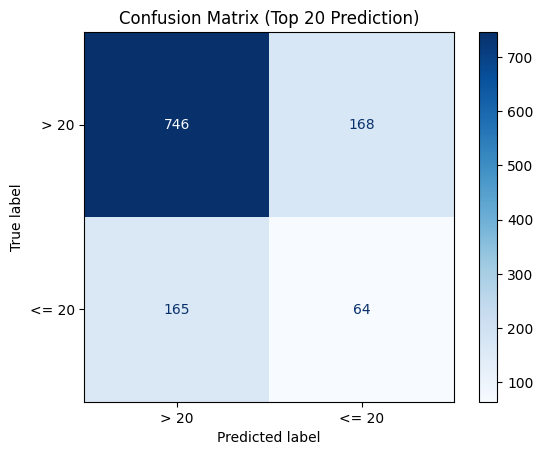


ROC AUC Score: 0.6075
Precision-Recall AUC Score: 0.2579


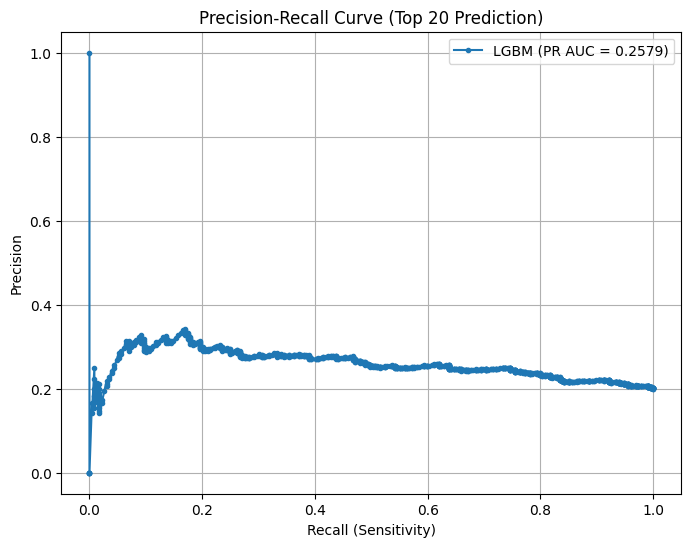

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import sys
import time


input_file_path = 'expanded_song_data_all_cols.csv'
ranking_threshold = 20

print(f"Reading expanded data from: {input_file_path}")
try:
    if input_file_path.endswith('.csv'):
        df = pd.read_csv(input_file_path)
    elif input_file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(input_file_path)
    else:
        print(f"Error: Unsupported file format for {input_file_path}. Please use CSV or Excel.", file=sys.stderr)
        df = None

    if df is None:
        sys.exit("Exiting due to file reading error.")

    print(f"Successfully read data. Shape: {df.shape}")

except FileNotFoundError:
    print(f"Error: The file '{input_file_path}' was not found.", file=sys.stderr)
    print("Please make sure the file exists and the path is correct.", file=sys.stderr)
    sys.exit("Exiting due to file not found.")
except Exception as e:
    print(f"\nAn error occurred during file reading: {e}", file=sys.stderr)
    sys.exit("Exiting due to file reading error.")

print("\nStarting preprocessing...")

lyrics_col_name = 'lyrics_cleaned' if 'lyrics_cleaned' in df.columns else 'lyrics'
if lyrics_col_name not in df.columns:
    print(f"ERROR: Neither 'lyrics_cleaned' nor 'lyrics' found in DataFrame.", file=sys.stderr)
    sys.exit("Exiting due to missing lyrics column.")

if 'ranking' not in df.columns:
    print("Error: 'ranking' column not found.", file=sys.stderr)
    sys.exit("Exiting due to missing ranking column.")
df['ranking'] = pd.to_numeric(df['ranking'], errors='coerce')

df_processed = df.dropna(subset=['ranking', lyrics_col_name]).copy()
print(f"Shape after dropping NaNs in ranking/lyrics: {df_processed.shape}")

target_col = 'is_top_20'
df_processed[target_col] = (df_processed['ranking'] <= ranking_threshold).astype(int)
print(f"\nTarget variable '{target_col}' created (1 if ranking <= {ranking_threshold}, 0 otherwise).")
print(f"Value counts for target:\n{df_processed[target_col].value_counts()}")


columns_to_drop = [
    'song', 'artist', 'year', 'ranking', 'MYCS',
    'year_list', 'ranking_list'
]
if 'lyrics_cleaned' in df.columns and 'lyrics' in df.columns:
    other_lyrics = 'lyrics' if lyrics_col_name == 'lyrics_cleaned' else 'lyrics_cleaned'
    columns_to_drop.append(other_lyrics)

y = df_processed[target_col]
columns_to_drop_existing = [col for col in columns_to_drop if col in df_processed.columns]
X = df_processed.drop(columns=columns_to_drop_existing + [target_col], errors='ignore')



lyrics_data = X.pop(lyrics_col_name)


X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.mean())
numerical_feature_names = X.columns.tolist()
print(f"Number of non-lyric features after preprocessing: {len(numerical_feature_names)}")


print("\nPerforming Train-Test Split...")
X_train_num, X_test_num, lyrics_train, lyrics_test, y_train, y_test = train_test_split(
    X, lyrics_data, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {X_train_num.shape[0]}, Test size: {X_test_num.shape[0]}")
print(f"Train target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")

print("\nApplying TF-IDF to lyrics (removing stopwords)...")

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
tfidf_train_sparse = vectorizer.fit_transform(lyrics_train)
tfidf_test_sparse = vectorizer.transform(lyrics_test)
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), columns=tfidf_feature_names)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), columns=tfidf_feature_names)
print(f"Number of TF-IDF features: {len(tfidf_feature_names)}")


print("\nCombining numerical features with TF-IDF features...")
X_train_combined = pd.concat([X_train_num.reset_index(drop=True), tfidf_train_df], axis=1)
X_test_combined = pd.concat([X_test_num.reset_index(drop=True), tfidf_test_df], axis=1)
combined_feature_names = X_train_combined.columns.tolist()
print(f"Total number of features after combining: {len(combined_feature_names)}")

print("\nScaling combined feature set...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

print("\nTraining LightGBM Classifier model with class_weight='balanced'...")
model_lgbm_clf_top20 = lgb.LGBMClassifier(objective='binary',
                                          metric='auc',
                                          class_weight='balanced',
                                          random_state=42,
                                          n_jobs=-1)
start_time = time.time()
model_lgbm_clf_top20.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"Model training finished in {end_time - start_time:.2f} seconds.")

y_pred_clf = model_lgbm_clf_top20.predict(X_test_scaled)
y_pred_proba_clf = model_lgbm_clf_top20.predict_proba(X_test_scaled)[:, 1]

print("\n--- Top 20 Classification Performance Metrics ---")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_clf, target_names=[f'Rank > {ranking_threshold}', f'Rank <= {ranking_threshold}']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'> {ranking_threshold}', f'<= {ranking_threshold}'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Top 20 Prediction)')
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_proba_clf)
print(f"\nROC AUC Score: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_clf)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'LGBM (PR AUC = {pr_auc:.4f})')
plt.title('Precision-Recall Curve (Top 20 Prediction)')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()



Reading expanded data from: expanded_song_data_all_cols.csv
Successfully read data. Shape: (5898, 68)

Starting preprocessing...
Target variable 'is_top_20' counts:
is_top_20
0    4565
1    1146
Name: count, dtype: int64

Applying TF-IDF...

Combining and Scaling Features...
Total features: 8449

Training Logistic Regression model with class_weight='balanced'...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Model training finished in 28.83 seconds.

--- Logistic Regression Top 20 Classification Performance Metrics ---

Classification Report:
              precision    recall  f1-score   support

   Rank > 20       0.80      0.92      0.86       914
  Rank <= 20       0.24      0.10      0.15       229

    accuracy                           0.75      1143
   macro avg       0.52      0.51      0.50      1143
weighted avg       0.69      0.75      0.71      1143


Confusion Matrix:


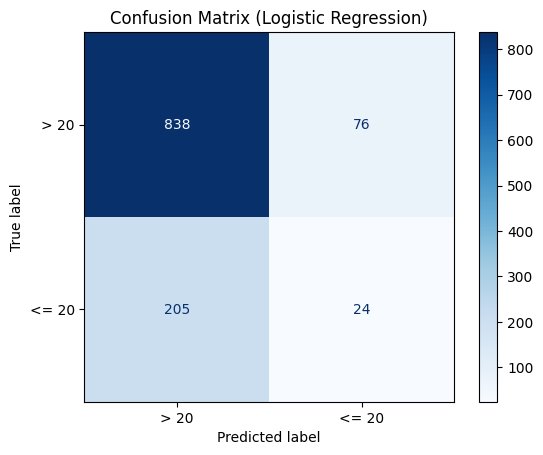


ROC AUC Score: 0.5269
Precision-Recall AUC Score: 0.2160


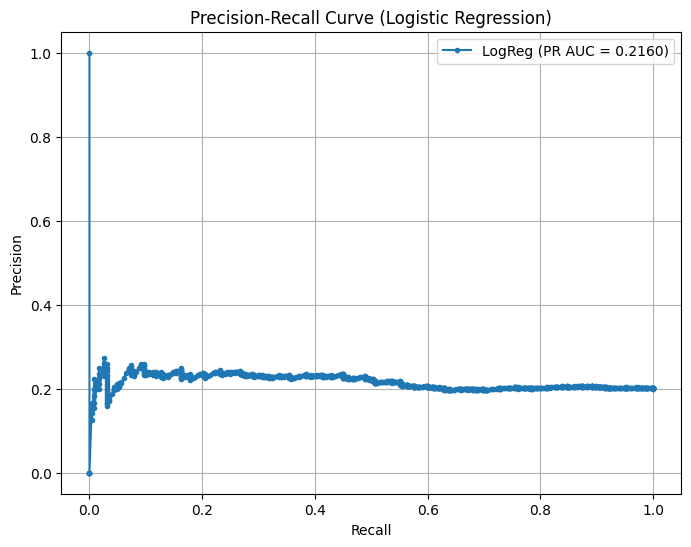

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import sys
import time

input_file_path = 'expanded_song_data_all_cols.csv'
ranking_threshold = 20

print(f"Reading expanded data from: {input_file_path}")
try:
    if input_file_path.endswith('.csv'):
        df = pd.read_csv(input_file_path)
    elif input_file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(input_file_path)
    else:
        print(f"Error: Unsupported file format for {input_file_path}. Please use CSV or Excel.", file=sys.stderr)
        df = None
    if df is None: sys.exit("Exiting due to file reading error.")
    print(f"Successfully read data. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {input_file_path}", file=sys.stderr)
    sys.exit("Exiting due to file not found.")
except Exception as e:
    print(f"\nAn error occurred during file reading: {e}", file=sys.stderr)
    sys.exit("Exiting due to file reading error.")

print("\nStarting preprocessing...")
lyrics_col_name = 'lyrics_cleaned' if 'lyrics_cleaned' in df.columns else 'lyrics'
if lyrics_col_name not in df.columns: sys.exit("Exiting due to missing lyrics column.")
if 'ranking' not in df.columns: sys.exit("Exiting due to missing ranking column.")
df['ranking'] = pd.to_numeric(df['ranking'], errors='coerce')
df_processed = df.dropna(subset=['ranking', lyrics_col_name]).copy()
target_col = 'is_top_20'
df_processed[target_col] = (df_processed['ranking'] <= ranking_threshold).astype(int)
print(f"Target variable '{target_col}' counts:\n{df_processed[target_col].value_counts()}")

columns_to_drop = ['song', 'artist', 'year', 'ranking', 'MYCS', 'year_list', 'ranking_list']
if 'lyrics_cleaned' in df.columns and 'lyrics' in df.columns:
    other_lyrics = 'lyrics' if lyrics_col_name == 'lyrics_cleaned' else 'lyrics_cleaned'
    columns_to_drop.append(other_lyrics)

y = df_processed[target_col]
columns_to_drop_existing = [col for col in columns_to_drop if col in df_processed.columns]
X = df_processed.drop(columns=columns_to_drop_existing + [target_col], errors='ignore')
lyrics_data = X.pop(lyrics_col_name)
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.mean())

X_train_num, X_test_num, lyrics_train, lyrics_test, y_train, y_test = train_test_split(
    X, lyrics_data, y, test_size=0.2, random_state=42, stratify=y
)

print("\nApplying TF-IDF...")
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
tfidf_train_sparse = vectorizer.fit_transform(lyrics_train)
tfidf_test_sparse = vectorizer.transform(lyrics_test)
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), columns=tfidf_feature_names)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), columns=tfidf_feature_names)

print("\nCombining and Scaling Features...")
X_train_combined = pd.concat([X_train_num.reset_index(drop=True), tfidf_train_df], axis=1)
X_test_combined = pd.concat([X_test_num.reset_index(drop=True), tfidf_test_df], axis=1)
combined_feature_names = X_train_combined.columns.tolist()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)
print(f"Total features: {len(combined_feature_names)}")

print("\nTraining Logistic Regression model with class_weight='balanced'...")
model_logreg_clf_top20 = LogisticRegression(class_weight='balanced',
                                           random_state=42,
                                           solver='liblinear',
                                           max_iter=1000,
                                           n_jobs=-1)
start_time = time.time()
model_logreg_clf_top20.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"Model training finished in {end_time - start_time:.2f} seconds.")

y_pred_clf = model_logreg_clf_top20.predict(X_test_scaled)
y_pred_proba_clf = model_logreg_clf_top20.predict_proba(X_test_scaled)[:, 1]

print("\n--- Logistic Regression Top 20 Classification Performance Metrics ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_clf, target_names=[f'Rank > {ranking_threshold}', f'Rank <= {ranking_threshold}']))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'> {ranking_threshold}', f'<= {ranking_threshold}'])
disp.plot(cmap=plt.cm.Blues); plt.title('Confusion Matrix (Logistic Regression)'); plt.show()
roc_auc = roc_auc_score(y_test, y_pred_proba_clf)
print(f"\nROC AUC Score: {roc_auc:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_clf)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")
plt.figure(figsize=(8, 6)); plt.plot(recall, precision, marker='.', label=f'LogReg (PR AUC = {pr_auc:.4f})');
plt.title('Precision-Recall Curve (Logistic Regression)'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.grid(True); plt.legend(); plt.show()



Reading expanded data from: expanded_song_data_all_cols.csv
Successfully read data. Shape: (5898, 68)

Starting preprocessing...
Target variable 'is_top_20' counts:
is_top_20
0    4565
1    1146
Name: count, dtype: int64

Applying TF-IDF...

Combining and Scaling Features...
Total features: 8449

Training Random Forest Classifier model with class_weight='balanced'...
Model training finished in 7.81 seconds.

--- Random Forest Top 20 Classification Performance Metrics ---

Classification Report:
              precision    recall  f1-score   support

   Rank > 20       0.80      0.98      0.88       914
  Rank <= 20       0.24      0.03      0.05       229

    accuracy                           0.79      1143
   macro avg       0.52      0.50      0.47      1143
weighted avg       0.69      0.79      0.71      1143


Confusion Matrix:


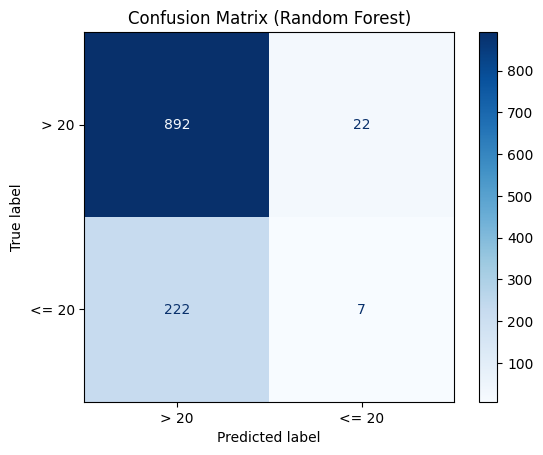


ROC AUC Score: 0.5926
Precision-Recall AUC Score: 0.2474


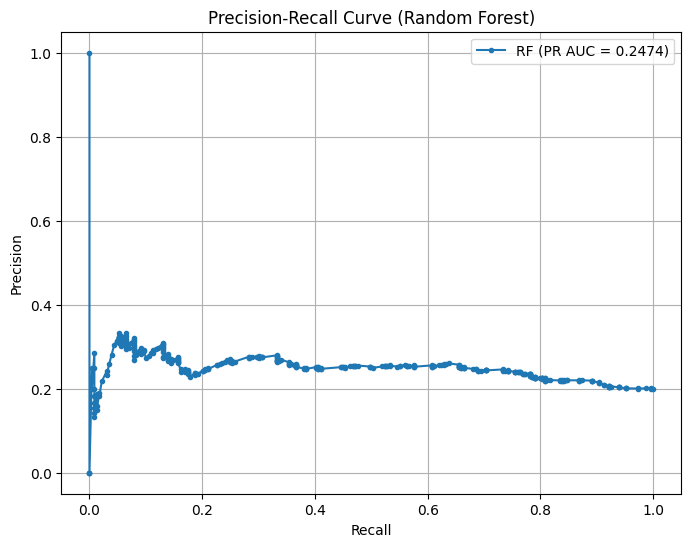

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import sys
import time

input_file_path = 'expanded_song_data_all_cols.csv'
ranking_threshold = 20

print(f"Reading expanded data from: {input_file_path}")
try:
    if input_file_path.endswith('.csv'):
        df = pd.read_csv(input_file_path)
    elif input_file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(input_file_path)
    else:
        print(f"Error: Unsupported file format for {input_file_path}. Please use CSV or Excel.", file=sys.stderr)
        df = None
    if df is None: sys.exit("Exiting due to file reading error.")
    print(f"Successfully read data. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {input_file_path}", file=sys.stderr)
    sys.exit("Exiting due to file not found.")
except Exception as e:
    print(f"\nAn error occurred during file reading: {e}", file=sys.stderr)
    sys.exit("Exiting due to file reading error.")

print("\nStarting preprocessing...")
lyrics_col_name = 'lyrics_cleaned' if 'lyrics_cleaned' in df.columns else 'lyrics'
if lyrics_col_name not in df.columns: sys.exit("Exiting due to missing lyrics column.")
if 'ranking' not in df.columns: sys.exit("Exiting due to missing ranking column.")
df['ranking'] = pd.to_numeric(df['ranking'], errors='coerce')
df_processed = df.dropna(subset=['ranking', lyrics_col_name]).copy()
target_col = 'is_top_20'
df_processed[target_col] = (df_processed['ranking'] <= ranking_threshold).astype(int)
print(f"Target variable '{target_col}' counts:\n{df_processed[target_col].value_counts()}")

columns_to_drop = ['song', 'artist', 'year', 'ranking', 'MYCS', 'year_list', 'ranking_list']
if 'lyrics_cleaned' in df.columns and 'lyrics' in df.columns:
    other_lyrics = 'lyrics' if lyrics_col_name == 'lyrics_cleaned' else 'lyrics_cleaned'
    columns_to_drop.append(other_lyrics)

y = df_processed[target_col]
columns_to_drop_existing = [col for col in columns_to_drop if col in df_processed.columns]
X = df_processed.drop(columns=columns_to_drop_existing + [target_col], errors='ignore')
lyrics_data = X.pop(lyrics_col_name)
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.mean())

X_train_num, X_test_num, lyrics_train, lyrics_test, y_train, y_test = train_test_split(
    X, lyrics_data, y, test_size=0.2, random_state=42, stratify=y
)

print("\nApplying TF-IDF...")
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
tfidf_train_sparse = vectorizer.fit_transform(lyrics_train)
tfidf_test_sparse = vectorizer.transform(lyrics_test)
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), columns=tfidf_feature_names)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), columns=tfidf_feature_names)

print("\nCombining and Scaling Features...")
X_train_combined = pd.concat([X_train_num.reset_index(drop=True), tfidf_train_df], axis=1)
X_test_combined = pd.concat([X_test_num.reset_index(drop=True), tfidf_test_df], axis=1)
combined_feature_names = X_train_combined.columns.tolist()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)
print(f"Total features: {len(combined_feature_names)}")

print("\nTraining Random Forest Classifier model with class_weight='balanced'...")
model_rf_clf_top20 = RandomForestClassifier(n_estimators=100,
                                            class_weight='balanced',
                                            random_state=42,
                                            n_jobs=-1)
start_time = time.time()
model_rf_clf_top20.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"Model training finished in {end_time - start_time:.2f} seconds.")

y_pred_clf = model_rf_clf_top20.predict(X_test_scaled)
y_pred_proba_clf = model_rf_clf_top20.predict_proba(X_test_scaled)[:, 1]

print("\n--- Random Forest Top 20 Classification Performance Metrics ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_clf, target_names=[f'Rank > {ranking_threshold}', f'Rank <= {ranking_threshold}']))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'> {ranking_threshold}', f'<= {ranking_threshold}'])
disp.plot(cmap=plt.cm.Blues); plt.title('Confusion Matrix (Random Forest)'); plt.show()
roc_auc = roc_auc_score(y_test, y_pred_proba_clf)
print(f"\nROC AUC Score: {roc_auc:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_clf)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")
plt.figure(figsize=(8, 6)); plt.plot(recall, precision, marker='.', label=f'RF (PR AUC = {pr_auc:.4f})');
plt.title('Precision-Recall Curve (Random Forest)'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.grid(True); plt.legend(); plt.show()



# Hyperparameter tuning for lightgbm

Reading expanded data from: expanded_song_data_all_cols.csv
Successfully read data. Shape: (5898, 68)

Starting preprocessing...
Target variable 'is_top_20' counts:
is_top_20
0    4565
1    1146
Name: count, dtype: int64

Applying TF-IDF...

Combining and Scaling Features...
Total features: 8449

Setting up Randomized Search for LightGBM...

Starting Randomized Search (trying 50 candidates)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 917, number of negative: 3651
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70500
[LightGBM] [Info] Number of data points in the train set: 4568, number of used features: 1056
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Tuned LightGBM Top 20 Classification Performance Metrics ---

Classification Report:
              precision    recall  f1-score   support

   Rank > 20       0.82      0.74      0.78       914
  Rank <= 20       0.26      0.37      0.31       229

    accuracy                           0.67      1143
   macro avg       0.54      0.56      0.54      1143
weighted avg       0.71      0.67      0.69      1143


Confusion Matrix:


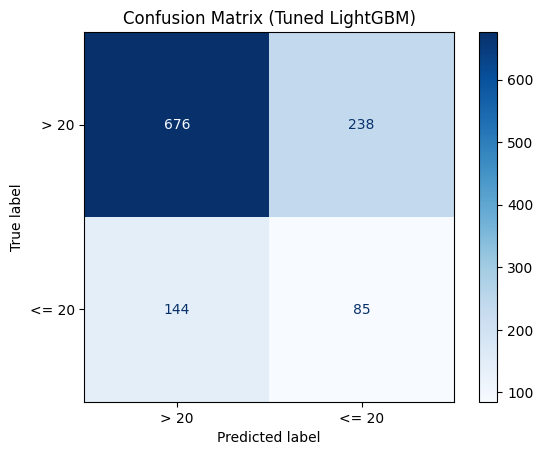


ROC AUC Score: 0.6092
Precision-Recall AUC Score: 0.2489


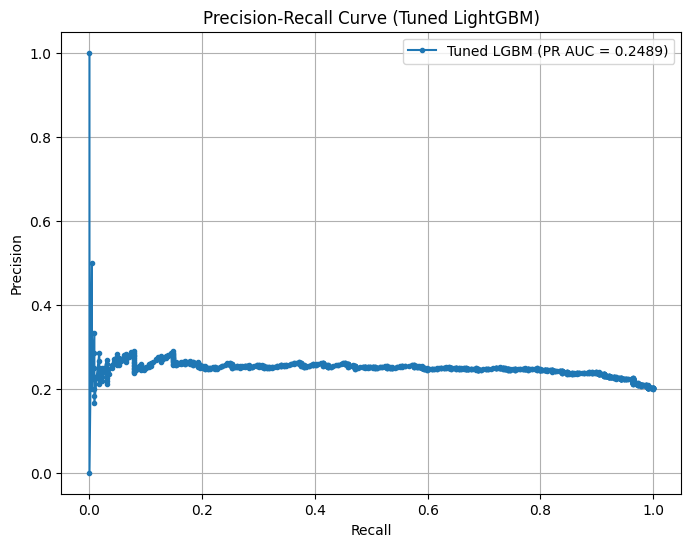

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_recall_curve,
    auc,
    make_scorer
)
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import sys
import time

input_file_path = 'expanded_song_data_all_cols.csv'
ranking_threshold = 20

print(f"Reading expanded data from: {input_file_path}")
try:
    if input_file_path.endswith('.csv'):
        df = pd.read_csv(input_file_path)
    elif input_file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(input_file_path)
    else:
        print(f"Error: Unsupported file format for {input_file_path}. Please use CSV or Excel.", file=sys.stderr)
        df = None
    if df is None: sys.exit("Exiting due to file reading error.")
    print(f"Successfully read data. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {input_file_path}", file=sys.stderr)
    sys.exit("Exiting due to file not found.")
except Exception as e:
    print(f"\nAn error occurred during file reading: {e}", file=sys.stderr)
    sys.exit("Exiting due to file reading error.")

print("\nStarting preprocessing...")
lyrics_col_name = 'lyrics_cleaned' if 'lyrics_cleaned' in df.columns else 'lyrics'
if lyrics_col_name not in df.columns: sys.exit("Exiting due to missing lyrics column.")
if 'ranking' not in df.columns: sys.exit("Exiting due to missing ranking column.")
df['ranking'] = pd.to_numeric(df['ranking'], errors='coerce')
df_processed = df.dropna(subset=['ranking', lyrics_col_name]).copy()
target_col = 'is_top_20'
df_processed[target_col] = (df_processed['ranking'] <= ranking_threshold).astype(int)
print(f"Target variable '{target_col}' counts:\n{df_processed[target_col].value_counts()}")

columns_to_drop = ['song', 'artist', 'year', 'ranking', 'MYCS', 'year_list', 'ranking_list']
if 'lyrics_cleaned' in df.columns and 'lyrics' in df.columns:
    other_lyrics = 'lyrics' if lyrics_col_name == 'lyrics_cleaned' else 'lyrics_cleaned'
    columns_to_drop.append(other_lyrics)

y = df_processed[target_col]
columns_to_drop_existing = [col for col in columns_to_drop if col in df_processed.columns]
X = df_processed.drop(columns=columns_to_drop_existing + [target_col], errors='ignore')
lyrics_data = X.pop(lyrics_col_name)
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.mean())

X_train_num, X_test_num, lyrics_train, lyrics_test, y_train, y_test = train_test_split(
    X, lyrics_data, y, test_size=0.2, random_state=42, stratify=y
)

print("\nApplying TF-IDF...")
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
tfidf_train_sparse = vectorizer.fit_transform(lyrics_train)
tfidf_test_sparse = vectorizer.transform(lyrics_test)
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), columns=tfidf_feature_names)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), columns=tfidf_feature_names)

print("\nCombining and Scaling Features...")
X_train_combined = pd.concat([X_train_num.reset_index(drop=True), tfidf_train_df], axis=1)
X_test_combined = pd.concat([X_test_num.reset_index(drop=True), tfidf_test_df], axis=1)
combined_feature_names = X_train_combined.columns.tolist() # Store feature names
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)
print(f"Total features: {len(combined_feature_names)}")


print("\nSetting up Randomized Search for LightGBM...")

param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 60),
    'max_depth': [-1, 5, 10, 15],
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

lgbm = lgb.LGBMClassifier(objective='binary',
                          class_weight='balanced',
                          random_state=42,
                          n_jobs=-1)


n_iter_search = 50
random_search = RandomizedSearchCV(estimator=lgbm,
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   cv=5,
                                   scoring='roc_auc',
                                   n_jobs=-1,
                                   random_state=42,
                                   verbose=1)

print(f"\nStarting Randomized Search (trying {n_iter_search} candidates)...")
start_time = time.time()
random_search.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"Randomized Search finished in {end_time - start_time:.2f} seconds.")

print("\nBest Parameters found by Randomized Search:")
print(random_search.best_params_)

best_lgbm_model = random_search.best_estimator_

y_pred_clf = best_lgbm_model.predict(X_test_scaled)
y_pred_proba_clf = best_lgbm_model.predict_proba(X_test_scaled)[:, 1]

print("\n--- Tuned LightGBM Top 20 Classification Performance Metrics ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_clf, target_names=[f'Rank > {ranking_threshold}', f'Rank <= {ranking_threshold}']))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'> {ranking_threshold}', f'<= {ranking_threshold}'])
disp.plot(cmap=plt.cm.Blues); plt.title('Confusion Matrix (Tuned LightGBM)'); plt.show()
roc_auc = roc_auc_score(y_test, y_pred_proba_clf)
print(f"\nROC AUC Score: {roc_auc:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_clf)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")
plt.figure(figsize=(8, 6)); plt.plot(recall, precision, marker='.', label=f'Tuned LGBM (PR AUC = {pr_auc:.4f})');
plt.title('Precision-Recall Curve (Tuned LightGBM)'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.grid(True); plt.legend(); plt.show()



Using best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 40, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8, 'random_state': 42, 'class_weight': 'balanced', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1}
Using top features for engineering: ['total_section_count', 'char_count', 'distinct_word_count', 'stopword_count', 'unique_word_count', 'repeated_phrase_intensity', 'syllable_count', 'word_count', 'chorus_ratio', 'bridge_ratio']
Reading expanded data from: expanded_song_data_all_cols.csv
Successfully read data. Shape: (5898, 68)

Starting preprocessing...
Target variable 'is_top_20' counts:
is_top_20
0    4565
1    1146
Name: count, dtype: int64

Starting feature engineering based on predefined top features...
Creating squared features for top 10...

Creating interaction features for top 10...

Performing Train-Test Split on augmented data...
Train size: 4568, Test size: 1143

Applying TF-IDF (max_features

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 917, number of negative: 3651
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83129
[LightGBM] [Info] Number of data points in the train set: 4568, number of used features: 1111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Final Tuned LightGBM (with predefined engineered features) Performance Metrics ---

Classification Report:
              precision    recall  f1-score   support

   Rank > 20       0.82      0.86      0.84       914
  Rank <= 20       0.29      0.23      0.26       229

    accuracy                           0.73      1143
   macro avg       0.55      0.54      0.55      1143
weighted avg       0.71      0.73      0.72      1143


Confusion Matrix:


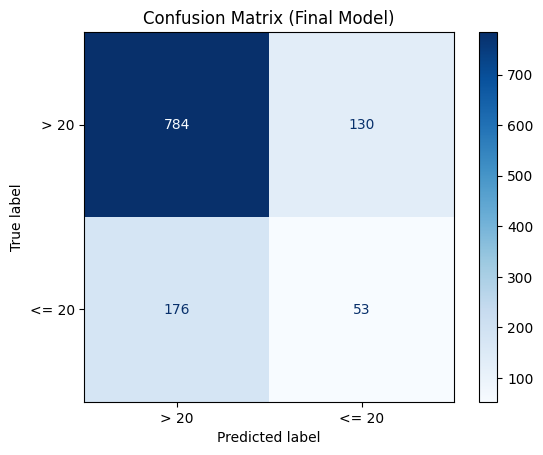


ROC AUC Score: 0.6092
Precision-Recall AUC Score: 0.2549


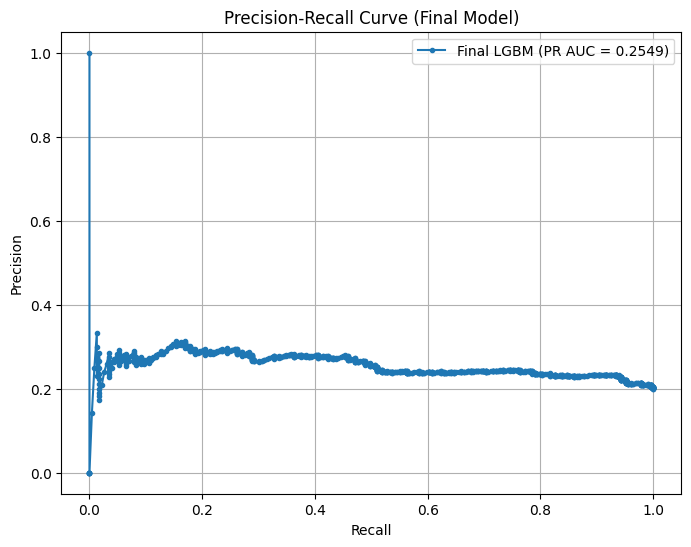


Feature Importances (Final Model - Top 50):
avg_word_length                                    139
pronoun_word_ratio                                 139
chorus_sentiment_shift                             133
second_person_ratio                                114
neu_ratio                                          107
first_person_ratio                                 102
lexical_diversity                                   97
neg_ratio                                           95
total_section_count_x_repeated_phrase_intensity     90
rhyme_density                                       88
bigram_repeated_phrase_intensity                    85
compound                                            82
love                                                77
dont                                                77
pos_ratio                                           75
like                                                74
repeated_phrase_intensity_x_chorus_ratio            74
know                

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_recall_curve,
    auc
)
from itertools import combinations
import matplotlib.pyplot as plt
import sys
import time

input_file_path = 'expanded_song_data_all_cols.csv'
ranking_threshold = 20

top_n_features_for_eng_list = [
    'total_section_count', 'char_count', 'distinct_word_count',
    'stopword_count', 'unique_word_count', 'repeated_phrase_intensity',
    'syllable_count', 'word_count', 'chorus_ratio', 'bridge_ratio'
]
n_top_features_for_eng = len(top_n_features_for_eng_list)
tfidf_max_features = 1000


best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.05,
    'max_depth': 10,
    'n_estimators': 300,
    'num_leaves': 40,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'subsample': 0.8,
    'random_state': 42,
    'class_weight':'balanced',
    'objective': 'binary',
    'metric': 'auc',
    'n_jobs': -1
}
print(f"Using best parameters: {best_params}")
print(f"Using top features for engineering: {top_n_features_for_eng_list}")


print(f"Reading expanded data from: {input_file_path}")
try:
    if input_file_path.endswith('.csv'):
        df = pd.read_csv(input_file_path)
    elif input_file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(input_file_path)
    else:
        print(f"Error: Unsupported file format for {input_file_path}.", file=sys.stderr)
        df = None
    if df is None: sys.exit("Exiting due to file reading error.")
    print(f"Successfully read data. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {input_file_path}", file=sys.stderr)
    sys.exit("Exiting due to file not found.")
except Exception as e:
    print(f"\nAn error occurred during file reading: {e}", file=sys.stderr)
    sys.exit("Exiting due to file reading error.")

print("\nStarting preprocessing...")
lyrics_col_name = 'lyrics_cleaned' if 'lyrics_cleaned' in df.columns else 'lyrics'
if lyrics_col_name not in df.columns: sys.exit("Exiting due to missing lyrics column.")
if 'ranking' not in df.columns: sys.exit("Exiting due to missing ranking column.")
df['ranking'] = pd.to_numeric(df['ranking'], errors='coerce')
df_processed = df.dropna(subset=['ranking', lyrics_col_name]).copy()
target_col = 'is_top_20'
df_processed[target_col] = (df_processed['ranking'] <= ranking_threshold).astype(int)
print(f"Target variable '{target_col}' counts:\n{df_processed[target_col].value_counts()}")

columns_to_drop = ['song', 'artist', 'year', 'ranking', 'MYCS', 'year_list', 'ranking_list']
if 'lyrics_cleaned' in df.columns and 'lyrics' in df.columns:
    other_lyrics = 'lyrics' if lyrics_col_name == 'lyrics_cleaned' else 'lyrics_cleaned'
    columns_to_drop.append(other_lyrics)

y = df_processed[target_col]
columns_to_drop_existing = [col for col in columns_to_drop if col in df_processed.columns]
X = df_processed.drop(columns=columns_to_drop_existing + [target_col], errors='ignore')
lyrics_data = X.pop(lyrics_col_name)

X_processed = pd.get_dummies(X, drop_first=True)
X_processed = X_processed.fillna(X_processed.mean())

print("\nStarting feature engineering based on predefined top features...")
X_engineered = X_processed.copy()

print(f"Creating squared features for top {n_top_features_for_eng}...")
for feature in top_n_features_for_eng_list:
    if feature in X_engineered.columns:
         if pd.api.types.is_numeric_dtype(X_engineered[feature]):
              new_col_name = f"{feature}_sq"
              X_engineered[new_col_name] = X_engineered[feature]**2
         else:
              print(f"  Skipping non-numeric feature for squaring: {feature}")
    else:
         print(f"  Warning: Top feature '{feature}' not found for squaring.")


print(f"\nCreating interaction features for top {n_top_features_for_eng}...")
for feat1, feat2 in combinations(top_n_features_for_eng_list, 2):
     if feat1 in X_engineered.columns and feat2 in X_engineered.columns:
          if pd.api.types.is_numeric_dtype(X_engineered[feat1]) and pd.api.types.is_numeric_dtype(X_engineered[feat2]):
                new_col_name = f"{feat1}_x_{feat2}"
                X_engineered[new_col_name] = X_engineered[feat1] * X_engineered[feat2]
          else:
               print(f"  Skipping interaction for non-numeric pair: {feat1}, {feat2}")
     else:
          print(f"  Warning: One or both features not found for interaction: {feat1}, {feat2}")


print("\nPerforming Train-Test Split on augmented data...")
X_train_num, X_test_num, lyrics_train, lyrics_test, y_train, y_test = train_test_split(
    X_engineered, lyrics_data, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {X_train_num.shape[0]}, Test size: {X_test_num.shape[0]}")

print(f"\nApplying TF-IDF (max_features={tfidf_max_features})...")
vectorizer = TfidfVectorizer(max_features=tfidf_max_features, stop_words='english', ngram_range=(1, 2))
tfidf_train_sparse = vectorizer.fit_transform(lyrics_train)
tfidf_test_sparse = vectorizer.transform(lyrics_test)
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), columns=tfidf_feature_names)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), columns=tfidf_feature_names)
print(f"Number of TF-IDF features: {len(tfidf_feature_names)}")


print("\nCombining all features...")
X_train_final = pd.concat([X_train_num.reset_index(drop=True), tfidf_train_df], axis=1)
X_test_final = pd.concat([X_test_num.reset_index(drop=True), tfidf_test_df], axis=1)
final_feature_names = X_train_final.columns.tolist()
print(f"Total features after combining: {len(final_feature_names)}")

print("\nScaling final combined feature set...")
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train_final)
X_test_scaled = scaler_final.transform(X_test_final)

print("\nTraining Final LightGBM Classifier model using best parameters...")
final_model = lgb.LGBMClassifier(**best_params)
start_time = time.time()
final_model.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"Model training finished in {end_time - start_time:.2f} seconds.")

y_pred_final = final_model.predict(X_test_scaled)
y_pred_proba_final = final_model.predict_proba(X_test_scaled)[:, 1]

print("\n--- Final Tuned LightGBM (with predefined engineered features) Performance Metrics ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=[f'Rank > {ranking_threshold}', f'Rank <= {ranking_threshold}']))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'> {ranking_threshold}', f'<= {ranking_threshold}'])
disp.plot(cmap=plt.cm.Blues); plt.title('Confusion Matrix (Final Model)'); plt.show()
roc_auc = roc_auc_score(y_test, y_pred_proba_final)
print(f"\nROC AUC Score: {roc_auc:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_final)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")
plt.figure(figsize=(8, 6)); plt.plot(recall, precision, marker='.', label=f'Final LGBM (PR AUC = {pr_auc:.4f})');
plt.title('Precision-Recall Curve (Final Model)'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.grid(True); plt.legend(); plt.show()

importances_final = final_model.feature_importances_
feature_importance_series_final = pd.Series(importances_final, index=final_feature_names)
sorted_feature_importance_final = feature_importance_series_final.sort_values(ascending=False)
print("\nFeature Importances (Final Model - Top 50):")
with pd.option_context('display.max_rows', 50):
    print(sorted_feature_importance_final.head(50))



In [ ]:
import joblib
import os
import sys



if 'best_lgbm_model' not in globals():
     print("ERROR: The variable 'best_lgbm_model' does not exist.", file=sys.stderr)
     print("Please ensure the previous tuning code block has run successfully and defined this variable.", file=sys.stderr)
else:
    save_dir = 'saved_models'
    model_filename = os.path.join(save_dir, 'tuned_lgbm_top20_classifier.joblib')

    os.makedirs(save_dir, exist_ok=True)

    try:
        joblib.dump(best_lgbm_model, model_filename)
        print(f"\nTuned LightGBM model successfully saved to: {model_filename}")



    except Exception as e:
        print(f"\nError saving the model: {e}", file=sys.stderr)




Tuned LightGBM model successfully saved to: saved_models/tuned_lgbm_top20_classifier.joblib


In [ ]:
import joblib
import os
import sys



if 'final_model' not in globals():
     print("ERROR: The variable 'final_model' does not exist.", file=sys.stderr)
     print("Please ensure the previous code block defining and training this model has run successfully.", file=sys.stderr)
else:
    # Define the directory and filename for the saved model
    save_dir = 'saved_models'
    # Use a distinct filename for this final model
    model_filename = os.path.join(save_dir, 'lgbm_final_engineered_top20_classifier.joblib')

    # Create the directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    try:
        # Save the model to the specified file using joblib
        joblib.dump(final_model, model_filename)
        print(f"\nFinal engineered LightGBM model successfully saved to: {model_filename}")

        # --- How to load the model later ---
        # print("\nTo load this specific model later, use:")
        # print(f"loaded_model = joblib.load('{model_filename}')")

    except Exception as e:
        print(f"\nError saving the final model: {e}", file=sys.stderr)




Final engineered LightGBM model successfully saved to: saved_models/lgbm_final_engineered_top20_classifier.joblib


In [ ]:
import joblib
import os
import sys

print("\n--- Starting to Save Model and Artifacts ---")

save_dir = 'saved_models_and_artifacts'
os.makedirs(save_dir, exist_ok=True)

try:
    if 'best_lgbm_model' in globals() and best_lgbm_model is not None:
        model_filename = os.path.join(save_dir, 'tuned_lgbm_top20_classifier.joblib')
        joblib.dump(best_lgbm_model, model_filename)
        print(f"Tuned LightGBM model saved to: {model_filename}")
    else:
        print("ERROR: 'best_lgbm_model' not found. Please ensure tuning completed and variable is set.", file=sys.stderr)
except Exception as e:
    print(f"Error saving the LightGBM model: {e}", file=sys.stderr)

# 2. Save the Fitted TfidfVectorizer
try:
    if 'vectorizer' in globals() and vectorizer is not None:
        vectorizer_filename = os.path.join(save_dir, 'tfidf_vectorizer.joblib')
        joblib.dump(vectorizer, vectorizer_filename)
        print(f"Fitted TfidfVectorizer saved to: {vectorizer_filename}")
    else:
        print("ERROR: 'vectorizer' object not found. Please ensure it was defined and fitted.", file=sys.stderr)
except Exception as e:
    print(f"Error saving the TfidfVectorizer: {e}", file=sys.stderr)

# 3. Save the Fitted StandardScaler
try:
    if 'scaler' in globals() and scaler is not None:
        scaler_filename = os.path.join(save_dir, 'standard_scaler.joblib')
        joblib.dump(scaler, scaler_filename)
        print(f"Fitted StandardScaler saved to: {scaler_filename}")
    else:
        print("ERROR: 'scaler' object not found. Please ensure it was defined and fitted.", file=sys.stderr)
except Exception as e:
    print(f"Error saving the StandardScaler: {e}", file=sys.stderr)

# 4. Save the List of Combined Feature Names
try:
    if 'combined_feature_names' in globals() and combined_feature_names is not None:
        feature_names_filename = os.path.join(save_dir, 'combined_feature_names.joblib')
        joblib.dump(combined_feature_names, feature_names_filename)
        print(f"Combined feature names list saved to: {feature_names_filename}")
    else:
        print("ERROR: 'combined_feature_names' list not found.", file=sys.stderr)
except Exception as e:
    print(f"Error saving the combined feature names list: {e}", file=sys.stderr)


try:
    if 'top_n_features_for_eng_list' in globals() and top_n_features_for_eng_list is not None:
        top_features_filename = os.path.join(save_dir, 'top_n_features_for_eng.joblib')
        joblib.dump(top_n_features_for_eng_list, top_features_filename)
        print(f"List of features for engineering saved to: {top_features_filename}")
    else:
        print("INFO: 'top_n_features_for_eng_list' not found or not applicable for this model version, skipping save.")
except Exception as e:
    print(f"Error saving the top_n_features_for_eng_list: {e}", file=sys.stderr)

print("\n--- Artifact Saving Process Attempted ---")



--- Starting to Save Model and Artifacts ---
Tuned LightGBM model saved to: saved_models_and_artifacts/tuned_lgbm_top20_classifier.joblib
Fitted TfidfVectorizer saved to: saved_models_and_artifacts/tfidf_vectorizer.joblib
Fitted StandardScaler saved to: saved_models_and_artifacts/standard_scaler.joblib
Combined feature names list saved to: saved_models_and_artifacts/combined_feature_names.joblib
INFO: 'top_n_features_for_eng_list' not found or not applicable for this model version, skipping save.

--- Artifact Saving Process Attempted ---


In [ ]:
import joblib
import os
import sys



print("\n--- Starting to Save Model and Artifacts to a New Folder ---")

new_save_dir = r"C:\Users\alind\Downloads\saved_models_final_version"

os.makedirs(new_save_dir, exist_ok=True)
print(f"Artifacts will be saved in: {new_save_dir}")

# 1. Save the Final Trained LightGBM Model
try:
    if 'final_model' in globals() and final_model is not None:
        model_filename = os.path.join(new_save_dir, 'lgbm_final_engineered_top20_classifier.joblib')
        joblib.dump(final_model, model_filename)
        print(f"Final LightGBM model saved to: {model_filename}")
    else:
        print("ERROR: 'final_model' not found. Please ensure training completed and variable is set.", file=sys.stderr)
except Exception as e:
    print(f"Error saving the final_model: {e}", file=sys.stderr)

# 2. Save the Fitted TfidfVectorizer
try:
    if 'vectorizer' in globals() and vectorizer is not None:
        vectorizer_filename = os.path.join(new_save_dir, 'tfidf_vectorizer.joblib')
        joblib.dump(vectorizer, vectorizer_filename)
        print(f"Fitted TfidfVectorizer saved to: {vectorizer_filename}")
    else:
        print("ERROR: 'vectorizer' object not found. Please ensure it was defined and fitted.", file=sys.stderr)
except Exception as e:
    print(f"Error saving the TfidfVectorizer: {e}", file=sys.stderr)

# 3. Save the Fitted StandardScaler (used for the final combined features)
try:
    if 'scaler_final' in globals() and scaler_final is not None:
        scaler_filename = os.path.join(new_save_dir, 'standard_scaler_final.joblib') # Slightly different name
        joblib.dump(scaler_final, scaler_filename)
        print(f"Fitted StandardScaler (scaler_final) saved to: {scaler_filename}")
    else:
        print("ERROR: 'scaler_final' object not found. Please ensure it was defined and fitted.", file=sys.stderr)
except Exception as e:
    print(f"Error saving the StandardScaler (scaler_final): {e}", file=sys.stderr)

# 4. Save the List of Final Combined Feature Names
try:
    if 'final_feature_names' in globals() and final_feature_names is not None:
        feature_names_filename = os.path.join(new_save_dir, 'final_combined_feature_names.joblib') # Slightly different name
        joblib.dump(final_feature_names, feature_names_filename)
        print(f"Final combined feature names list saved to: {feature_names_filename}")
    else:
        print("ERROR: 'final_feature_names' list not found.", file=sys.stderr)
except Exception as e:
    print(f"Error saving the final combined feature names list: {e}", file=sys.stderr)

# 5. Save the top_n_features_for_eng_list
try:
    if 'top_n_features_for_eng_list' in globals() and top_n_features_for_eng_list is not None:
        top_features_filename = os.path.join(new_save_dir, 'top_n_features_for_eng.joblib')
        joblib.dump(top_n_features_for_eng_list, top_features_filename)
        print(f"List of features for engineering saved to: {top_features_filename}")
    else:
        print("ERROR: 'top_n_features_for_eng_list' not found. Please ensure it was defined.", file=sys.stderr)
except Exception as e:
    print(f"Error saving the top_n_features_for_eng_list: {e}", file=sys.stderr)

print("\n--- Artifact Saving Process to New Folder Attempted ---")



--- Starting to Save Model and Artifacts to a New Folder ---
Artifacts will be saved in: C:\Users\alind\Downloads\saved_models_final_version
Final LightGBM model saved to: C:\Users\alind\Downloads\saved_models_final_version/lgbm_final_engineered_top20_classifier.joblib
Fitted TfidfVectorizer saved to: C:\Users\alind\Downloads\saved_models_final_version/tfidf_vectorizer.joblib
Fitted StandardScaler (scaler_final) saved to: C:\Users\alind\Downloads\saved_models_final_version/standard_scaler_final.joblib
Final combined feature names list saved to: C:\Users\alind\Downloads\saved_models_final_version/final_combined_feature_names.joblib
List of features for engineering saved to: C:\Users\alind\Downloads\saved_models_final_version/top_n_features_for_eng.joblib

--- Artifact Saving Process to New Folder Attempted ---


In [ ]:
# prompt: load the columns of /content/final_clean_to_do_interaction_features.csv

df = pd.read_csv('/content/final_clean_to_do_interaction_features.csv')
df.columns


Index(['song', 'artist', 'year', 'ranking', 'MYCS', 'lyrics_cleaned', 'lyrics',
       'word_count', 'char_count', 'unique_word_count', 'unique_words',
       'distinct_word_count', 'avg_word_length', 'stopword_ratio', 'pos_ratio',
       'neg_ratio', 'neu_ratio', 'compound', 'lexical_diversity',
       'syllable_count', 'rhyme_pairs', 'rhyme_density', 'stopword_count',
       'distinct_stopword_count', 'stopword_repetition_ratio',
       'true_repetition_ratio', 'vocab_redundancy_ratio', 'first_person',
       'second_person', 'third_person', 'male_pronouns', 'female_pronouns',
       'total_pronouns', 'pronoun_word_ratio', 'first_person_ratio',
       'second_person_ratio', 'third_person_ratio', 'male_pronoun_ratio',
       'female_pronoun_ratio', 'verse_count', 'intro_count', 'outro_count',
       'bridge_count', 'chorus_count', 'prechorus_count', 'postchorus_count',
       'total_section_count', 'chorus_ratio', 'prechorus_ratio', 'verse_ratio',
       'bridge_ratio', 'pattern', 'se

In [ ]:

combined_feature_names


['word_count',
 'char_count',
 'unique_word_count',
 'distinct_word_count',
 'avg_word_length',
 'stopword_ratio',
 'pos_ratio',
 'neg_ratio',
 'neu_ratio',
 'compound',
 'lexical_diversity',
 'syllable_count',
 'rhyme_pairs',
 'rhyme_density',
 'stopword_count',
 'distinct_stopword_count',
 'stopword_repetition_ratio',
 'true_repetition_ratio',
 'vocab_redundancy_ratio',
 'first_person',
 'second_person',
 'third_person',
 'male_pronouns',
 'female_pronouns',
 'total_pronouns',
 'pronoun_word_ratio',
 'first_person_ratio',
 'second_person_ratio',
 'third_person_ratio',
 'male_pronoun_ratio',
 'female_pronoun_ratio',
 'verse_count',
 'intro_count',
 'outro_count',
 'bridge_count',
 'chorus_count',
 'prechorus_count',
 'postchorus_count',
 'total_section_count',
 'chorus_ratio',
 'prechorus_ratio',
 'verse_ratio',
 'bridge_ratio',
 'section_0',
 'section_1',
 'section_2',
 'section_3',
 'section_4',
 'section_5',
 'section_6',
 'section_7',
 'section_8',
 'section_9',
 'section_10',
 's

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_recall_curve,
    auc,
    make_scorer
)
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import sys
import time

input_file_path = 'expanded_song_data_all_cols.csv'
ranking_threshold = 20

print(f"Reading expanded data from: {input_file_path}")
try:
    if input_file_path.endswith('.csv'):
        df = pd.read_csv(input_file_path)
    elif input_file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(input_file_path)
    else:
        print(f"Error: Unsupported file format for {input_file_path}. Please use CSV or Excel.", file=sys.stderr)
        df = None
    if df is None: sys.exit("Exiting due to file reading error.")
    print(f"Successfully read data. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {input_file_path}", file=sys.stderr)
    sys.exit("Exiting due to file not found.")
except Exception as e:
    print(f"\nAn error occurred during file reading: {e}", file=sys.stderr)
    sys.exit("Exiting due to file reading error.")

print("\nStarting preprocessing...")
lyrics_col_name = 'lyrics_cleaned' if 'lyrics_cleaned' in df.columns else 'lyrics'
if lyrics_col_name not in df.columns: sys.exit("Exiting due to missing lyrics column.")
if 'ranking' not in df.columns: sys.exit("Exiting due to missing ranking column.")
df['ranking'] = pd.to_numeric(df['ranking'], errors='coerce')
df_processed = df.dropna(subset=['ranking', lyrics_col_name]).copy()
target_col = 'is_top_20'
df_processed[target_col] = (df_processed['ranking'] <= ranking_threshold).astype(int)
print(f"Target variable '{target_col}' counts:\n{df_processed[target_col].value_counts()}")

columns_to_drop = ['song', 'artist', 'year', 'ranking', 'MYCS', 'year_list', 'ranking_list']
if 'lyrics_cleaned' in df.columns and 'lyrics' in df.columns:
    other_lyrics = 'lyrics' if lyrics_col_name == 'lyrics_cleaned' else 'lyrics_cleaned'
    columns_to_drop.append(other_lyrics)

y = df_processed[target_col]
columns_to_drop_existing = [col for col in columns_to_drop if col in df_processed.columns]
X = df_processed.drop(columns=columns_to_drop_existing + [target_col], errors='ignore')
lyrics_data = X.pop(lyrics_col_name)
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.mean())

X_train_num, X_test_num, lyrics_train, lyrics_test, y_train, y_test = train_test_split(
    X, lyrics_data, y, test_size=0.2, random_state=42, stratify=y
)

print("\nApplying TF-IDF...")
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
tfidf_train_sparse = vectorizer.fit_transform(lyrics_train)
tfidf_test_sparse = vectorizer.transform(lyrics_test)
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), columns=tfidf_feature_names)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), columns=tfidf_feature_names)

print("\nCombining and Scaling Features...")
X_train_combined = pd.concat([X_train_num.reset_index(drop=True), tfidf_train_df], axis=1)
X_test_combined = pd.concat([X_test_num.reset_index(drop=True), tfidf_test_df], axis=1)
combined_feature_names = X_train_combined.columns.tolist()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)
print(f"Total features: {len(combined_feature_names)}")


print("\nSetting up Randomized Search for LightGBM...")

param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 60),
    'max_depth': [-1, 5, 10, 15],
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}


lgbm = lgb.LGBMClassifier(objective='binary',
                          class_weight='balanced',
                          random_state=42,
                          n_jobs=-1)


n_iter_search = 50
random_search = RandomizedSearchCV(estimator=lgbm,
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   cv=5,
                                   scoring='roc_auc',
                                   n_jobs=-1,
                                   random_state=42,
                                   verbose=1)

print(f"\nStarting Randomized Search (trying {n_iter_search} candidates)...")
start_time = time.time()
random_search.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"Randomized Search finished in {end_time - start_time:.2f} seconds.")

print("\nBest Parameters found by Randomized Search:")
print(random_search.best_params_)

best_lgbm_model = random_search.best_estimator_

y_pred_clf = best_lgbm_model.predict(X_test_scaled)
y_pred_proba_clf = best_lgbm_model.predict_proba(X_test_scaled)[:, 1]

print("\n--- Tuned LightGBM Top 20 Classification Performance Metrics ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_clf, target_names=[f'Rank > {ranking_threshold}', f'Rank <= {ranking_threshold}']))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'> {ranking_threshold}', f'<= {ranking_threshold}'])
disp.plot(cmap=plt.cm.Blues); plt.title('Confusion Matrix (Tuned LightGBM)'); plt.show()
roc_auc = roc_auc_score(y_test, y_pred_proba_clf)
print(f"\nROC AUC Score: {roc_auc:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_clf)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")
plt.figure(figsize=(8, 6)); plt.plot(recall, precision, marker='.', label=f'Tuned LGBM (PR AUC = {pr_auc:.4f})');
plt.title('Precision-Recall Curve (Tuned LightGBM)'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.grid(True); plt.legend(); plt.show()



In [ ]:
pip install imbalanced-learn


Reading expanded data from: expanded_song_data_all_cols.csv
Successfully read data. Shape: (5898, 68)

Starting preprocessing...
Target variable 'is_top_20' counts:
is_top_20
0    4565
1    1146
Name: count, dtype: int64

Applying TF-IDF...

Combining and Scaling Features...

Applying SMOTE to address class imbalance...
Post-SMOTE class distribution:
is_top_20
1    3651
0    3651
Name: count, dtype: int64

Setting up Randomized Search for LightGBM...

Starting Randomized Search (trying 50 candidates)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3651, number of negative: 3651
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107404
[LightGBM] [Info] Number of data points in the train set: 7302, number of used features: 1089
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Randomized Search finished in 6998.01 seconds.

Best Parameters found by Randomized Search:
{'colsample_bytree': np.float64(0.6003115063364057), 'learning_rate': np.float64(0.20844231185824352), 'max_depth': -1, 'n_estimators': 413, 'num_leaves': 41, 'reg_alpha': np.float64(0.007066305219717406), 'reg_lambda': np.float64(0.023062425041415757), 'subsample': np.float64(0.8099098641033556)}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Tuned LightGBM Top 20 Classification Performance Metrics ---

Classification Report:
              precision    recall  f1-score   support

   Rank > 20       0.80      0.95      0.87       914
  Rank <= 20       0.25      0.06      0.10       229

    accuracy                           0.78      1143
   macro avg       0.53      0.51      0.48      1143
weighted avg       0.69      0.78      0.72      1143


Confusion Matrix:


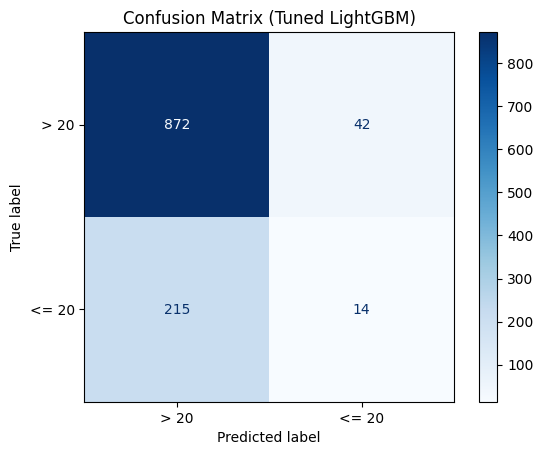


ROC AUC Score: 0.5903
Precision-Recall AUC Score: 0.2432


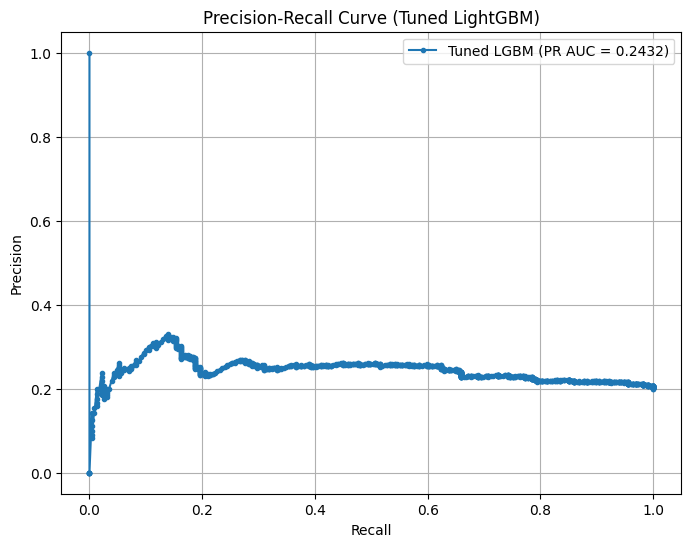

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_recall_curve,
    auc
)
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import sys
import time
from imblearn.over_sampling import SMOTE

input_file_path = 'expanded_song_data_all_cols.csv'
ranking_threshold = 20

print(f"Reading expanded data from: {input_file_path}")
try:
    if input_file_path.endswith('.csv'):
        df = pd.read_csv(input_file_path)
    elif input_file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(input_file_path)
    else:
        print(f"Error: Unsupported file format for {input_file_path}. Please use CSV or Excel.", file=sys.stderr)
        df = None
    if df is None:
        sys.exit("Exiting due to file reading error.")
    print(f"Successfully read data. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {input_file_path}", file=sys.stderr)
    sys.exit("Exiting due to file not found.")
except Exception as e:
    print(f"\nAn error occurred during file reading: {e}", file=sys.stderr)
    sys.exit("Exiting due to file reading error.")

print("\nStarting preprocessing...")
lyrics_col_name = 'lyrics_cleaned' if 'lyrics_cleaned' in df.columns else 'lyrics'
if lyrics_col_name not in df.columns:
    sys.exit("Exiting due to missing lyrics column.")
if 'ranking' not in df.columns:
    sys.exit("Exiting due to missing ranking column.")
df['ranking'] = pd.to_numeric(df['ranking'], errors='coerce')
df_processed = df.dropna(subset=['ranking', lyrics_col_name]).copy()
target_col = 'is_top_20'
df_processed[target_col] = (df_processed['ranking'] <= ranking_threshold).astype(int)
print(f"Target variable '{target_col}' counts:\n{df_processed[target_col].value_counts()}")

columns_to_drop = ['song', 'artist', 'year', 'ranking', 'MYCS', 'year_list', 'ranking_list']
if 'lyrics_cleaned' in df.columns and 'lyrics' in df.columns:
    other_lyrics = 'lyrics' if lyrics_col_name == 'lyrics_cleaned' else 'lyrics_cleaned'
    columns_to_drop.append(other_lyrics)

y = df_processed[target_col]
columns_to_drop_existing = [col for col in columns_to_drop if col in df_processed.columns]
X = df_processed.drop(columns=columns_to_drop_existing + [target_col], errors='ignore')
lyrics_data = X.pop(lyrics_col_name)
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.mean())

X_train_num, X_test_num, lyrics_train, lyrics_test, y_train, y_test = train_test_split(
    X, lyrics_data, y, test_size=0.2, random_state=42, stratify=y
)

print("\nApplying TF-IDF...")
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
tfidf_train_sparse = vectorizer.fit_transform(lyrics_train)
tfidf_test_sparse = vectorizer.transform(lyrics_test)
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), columns=tfidf_feature_names)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), columns=tfidf_feature_names)

print("\nCombining and Scaling Features...")
X_train_combined = pd.concat([X_train_num.reset_index(drop=True), tfidf_train_df], axis=1)
X_test_combined = pd.concat([X_test_num.reset_index(drop=True), tfidf_test_df], axis=1)
combined_feature_names = X_train_combined.columns.tolist()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

print("\nApplying SMOTE to address class imbalance...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print(f"Post-SMOTE class distribution:\n{pd.Series(y_train_resampled).value_counts()}")

print("\nSetting up Randomized Search for LightGBM...")

param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 60),
    'max_depth': [-1, 5, 10, 15],
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

lgbm = lgb.LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

n_iter_search = 50
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print(f"\nStarting Randomized Search (trying {n_iter_search} candidates)...")
start_time = time.time()
random_search.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
print(f"Randomized Search finished in {end_time - start_time:.2f} seconds.")

print("\nBest Parameters found by Randomized Search:")
print(random_search.best_params_)

best_lgbm_model = random_search.best_estimator_

y_pred_clf = best_lgbm_model.predict(X_test_scaled)
y_pred_proba_clf = best_lgbm_model.predict_proba(X_test_scaled)[:, 1]

print("\n--- Tuned LightGBM Top 20 Classification Performance Metrics ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_clf, target_names=[f'Rank > {ranking_threshold}', f'Rank <= {ranking_threshold}']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'> {ranking_threshold}', f'<= {ranking_threshold}'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Tuned LightGBM)')
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_proba_clf)
print(f"\nROC AUC Score: {roc_auc:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_clf)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Tuned LGBM (PR AUC = {pr_auc:.4f})')
plt.title('Precision-Recall Curve (Tuned LightGBM)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()
